In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import itertools
import pandas as pd
from tqdm import trange 
from mnist import MNIST


## Image segmentation + Resampling

In [2]:
def rescale_segment( segment, size = [28,28], pad = 0 ):
    '''function for resizing (scaling down) images
    input parameters
    seg : the segment of image (np.array)
    size : out size (list of two integers)
    output 
    scaled down image'''
    if len(segment.shape) == 3 : # Non Binary Image
        import cv2
        # thresholding the image
        ret,segment = cv2.threshold(segment,127,255,cv2.THRESH_BINARY)
    m,n = segment.shape
    idx1 = list(range(0,m, (m)//(size[0]) ) )
    idx2 = list(range(0,n, n//(size[1]) )) 
    out = np.zeros(size)
    for i in range(size[0]):
        for j in range(size[1]):
            out[i,j] = segment[ idx1[i] + (m%size[0])//2, idx2[j] + (n%size[0])//2]
#     if pad
    return out

def extract_segments(img, pad=30, reshape = 0,size = [28,28]) :
    '''function to extract individual chacters and digits from an image
    input paramterts
    img : input image (numpy array)
    pad : padding window size around segments (int)
    size : out size (list of two integers)
    reshape : if 1 , output will be scaled down. if 0, no scaling down
    Returns
    out : list of each segments (starting from leftmost digit)'''
    
    import cv2
    # thresholding the image
    ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    print(thresh1)
    # Negative tranform gray levels (background becomes black) 
    thresh1 = thresh1 - 1
    thresh1[thresh1 == 254] = 0
    thresh1[thresh1 == - 1 ] = 255
    
    # connected component labelling 
    output = cv2.connectedComponentsWithStats(thresh1, 4)
    final = []
    temp1 = np.sort( output[2][:,0] )
    kernel = np.ones( [3,3])
    for i in range(1,output[0]):
        temp2 = output[2]
        cord = np.squeeze( temp2[temp2[:,0] == temp1[i]] )
        num = np.pad( thresh1[ cord[1]:cord[1]+cord[3], cord[0]:cord[0]+cord[2] ], pad,'constant')
        num = cv2.dilate(num,kernel,iterations = 1)
        if reshape == 1:
            num = rescale_segment( num, size )
        final.append(num)        
    return final

def collate_symbols(symbol_id,sym_filename,img_filename): 
    """function strive to create dataset from HAsy by scanning given csv file for desired symbol(symbol_id)
    parameters:
    symbol_id:(type integer) id of symbol to be saved in csv
    sym_filename:(type string) filename of csv file containing the symbols
    img_filename:(type string) filename of csv file containing the matrix values of the images"""
    import csv
    latex_val = [train1["latex"][train1["symbol_id"]==symbol_id].iloc[0]]
    #print(type(latex_val));
    folder_loc = 'C:/Users/pmath/Documents/271B project/'
    for i,file_loc in enumerate(train1["path"][train1["symbol_id"]==symbol_id]):
        img1 = cv2.imread(folder_loc + file_loc,0);
        img1 = (255 -img1)/255;
        img1 = np.pad(img1,12,'constant',constant_values=(0,0));
        kernel = np.ones((2,2),np.uint8);
        img1 = cv2.dilate(img1,kernel,iterations = 1)
        img1 = rescale_segment(img1,[28,28]);
        row = img1.reshape(1,-1).tolist();
        row = row[0]; 
        with open(img_filename,"a",newline='') as fp:
            wr = csv.writer(fp, dialect='excel')
            wr.writerow(row);
        with open(sym_filename,"a",newline='') as fp:
            wr = csv.writer(fp, dialect='excel')
            wr.writerow(latex_val);
            
def collate_numbers(images,labels,num_img_filename,num_sym_filename):
    """function creates csv files (one for images and another for the labels provided).
    parameters:
    images:(type list)list of images loaded """
    import csv
    train_images = np.array(images);
    train_images = (train_images)/255;
    train_labels = np.array(labels);
        
    num_imgs = train_images.shape[0];

    permutation = list(np.random.permutation(num_imgs));
    shuffled_x = train_images[permutation,:];
    shuffled_t = train_labels[permutation];
    
    batch = zip(shuffled_x,shuffled_t);
    for i,(x,t) in enumerate(batch):
        if(i>20000):
            break;
        with open(num_img_filename,"a",newline='') as fp:
            wr = csv.writer(fp, dialect='excel')
            wr.writerow(x.tolist());   
        with open(num_sym_filename,"a",newline='') as fp:
            wr = csv.writer(fp, dialect='excel')
            wr.writerow([t]);
        

## HASy dataset collection

In [3]:
path = './hasy-data-labels.csv';
train1 = pd.read_csv(path);
print(train1.head());
sym_filename = "./CSV folder/labels_symbols.csv";
img_filename = "./CSV folder/imgs_symbols.csv";
symbols = [922,81,187,188,195,196,267,526,513];
for i in symbols:
    collate_symbols(i,sym_filename,img_filename);

                     path  symbol_id latex  user_id
0  hasy-data/v2-00000.png         31     A       50
1  hasy-data/v2-00001.png         31     A       10
2  hasy-data/v2-00002.png         31     A       43
3  hasy-data/v2-00003.png         31     A       43
4  hasy-data/v2-00004.png         31     A     4435


| Symbols | symbol_id |
|:---------|-----------|:-
| pi| 81|
| < | 187|
|>|188|
|-|195|
|+|196|
|%|267|
| division | 526 |
| multiply | 513 |



## MNIST  data collection

In [4]:
mndata_train = MNIST('./training set');
mndata_train.gz = True;
images,labels = mndata_train.load_training();
num_img_filename = "./CSV folder/imgs_nums.csv"
num_sym_filename =  "./CSV folder/labels_nums.csv"
collate_numbers(images,labels,num_img_filename,num_sym_filename)#,img_data_filename,num_data_filename);

## Hasy data visualization

In [5]:
data = np.array(pd.read_csv(img_filename))*255;
data.shape

(5218, 784)

18


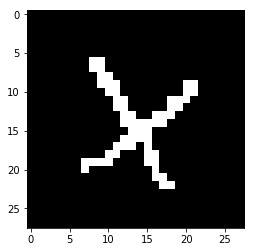

In [6]:
loc = np.random.randint(200);
v1 = data[-1,:];
print(loc);
plt.imshow(v1.reshape(28,28),cmap='gray')
plt.show();

## MNIST data visualization

In [7]:
data = np.array(pd.read_csv(num_img_filename))*255;
data.shape

(20000, 784)

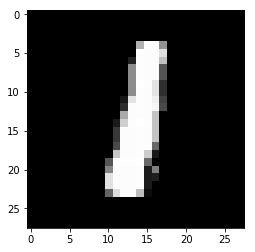

In [8]:
v1 = data[2,:];
plt.imshow(v1.reshape(28,28),cmap='gray')
plt.show();

## Combining CSV files

In [9]:
data_nums = np.array(pd.read_csv(num_img_filename));
data_syms = np.array(pd.read_csv(img_filename));
label_nums = np.array(pd.read_csv(num_sym_filename));
label_syms = np.array(pd.read_csv(sym_filename));
print(data_nums.shape);
print(data_syms.shape);
data = np.vstack((data_nums,data_syms));
labels = np.vstack((label_nums,label_syms));
print(data.shape);
print(labels.shape)
num_ex = data.shape[0];
permutation = list(np.random.permutation(num_ex));
final_data = data[permutation,:];
final_labels = labels[permutation,:];

(20000, 784)
(5218, 784)
(25218, 784)
(25218, 1)


In [10]:
import csv
img_filename = "./CSV folder/final_data.csv";
label_filename = "./CSV folder/final_label.csv";
batch = zip(final_data,final_labels);
for idx,(x,t) in enumerate(batch):
    with open(img_filename,"a",newline='') as fp:
        wr = csv.writer(fp, dialect='excel')
        wr.writerow(x.tolist());
    with open(label_filename,"a",newline='') as fp:
        wr = csv.writer(fp, dialect='excel')
        wr.writerow(t.tolist());